In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import librosa
from IPython.display import Audio 
from IPython.core.display import display

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split 
from sklearn.metrics import classification_report, confusion_matrix
from keras.utils.np_utils import to_categorical

from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation
from keras.callbacks import ModelCheckpoint, EarlyStopping

import os
from collections import Counter
from datetime import datetime

# 특징 직접 추출

In [13]:
n_mfcc = 60
def extract_features(file_name):
    try:
        y, sr = librosa.load(file_name, res_type='kaiser_fast') 
        mfcc = librosa.feature.mfcc(y=y, sr=sr, n_mfcc=n_mfcc)
        mfccScaled = np.mean(mfcc.T,axis=0)
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        print(e)
        return None 
     
    return mfccScaled

In [ ]:
# 여기는 각자 경로에 맞게
generalSoundPath = 'E:/Audio-TrainDataset/General-Sounds/'
legalVoicePath = 'E:/Audio-TrainDataset/Legal-Voices/'
illegalVoicePath = 'E:/Audio-TrainDataset/Illegal-Voices/'
noSoundPath = 'E:/Audio-TrainDataset/No-Sounds/'

def fetchDataset(path, class_label):
    features = []
    filename_list = []
    for dirpath, dirnames, filenames in os.walk(path):
        print(dirpath)
        filename_list = filename_list + filenames
        for filename in filenames:
            file_name = os.path.join(dirpath, filename)
            data = extract_features(file_name)
            features.append([data, class_label])
    return features, filename_list
            
start = datetime.now()

# gs, gs_name = fetchDataset(generalSoundPath, 'General Sound')
# lv, lv_name = fetchDataset(legalVoicePath, 'Legal Voice')
# iv, iv_name = fetchDataset(illegalVoicePath, 'Illegal Voice')
# ns, ns_name = fetchDataset(noSoundPath, 'No Sound')

duration = datetime.now() - start
print(duration)

In [ ]:
# 문제아 테스트
# extract_features('E:/Audio-TrainDataset/Illegal-Voices/V-UA-VIL-0000045383.wav')

# 추출한 특징 파일로 저장

In [ ]:
def write_features(file_name, dataset):
    with open(file_name, 'w') as f:
        for item1 in dataset:
            for item2 in item1[0]:
                f.write("%s " % item2)
            f.write('\n')

def write_filenames(file_name, name_list):
    with open(file_name, 'w') as f:
        for item1 in name_list:
            f.write("%s\n" % item1)

In [ ]:
# write_features('E:/특징 추출/mfcc (60,)/General-Sounds.txt', gs)
# write_features('E:/특징 추출/mfcc (60,)/Legal-Voices.txt', lv)
# write_features('E:/특징 추출/mfcc (60,)/Illegal-Voices.txt', iv)
# write_features('E:/특징 추출/mfcc (60,)/No-Sounds.txt', ns)

# write_filenames('E:/파일명/General-Sounds.txt', gs_name)
# write_filenames('E:/파일명/Legal-Voices.txt', lv_name)
# write_filenames('E:/파일명/Illegal-Voices.txt', iv_name)
# write_filenames('E:/파일명/No-Sounds.txt', ns_name)

# 저장한 특징 불러오기

In [2]:
# [[np.arange(60), "hello"], [np.arange(60), "hi"]] 형태

def read_features(file_name, feature_label):
    dataset = []
    with open(file_name, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break
            dataset.append([np.fromiter(line.split(), dtype=np.float32), feature_label])
    return dataset

def read_filenames(file_name):
    name_list = []
    with open(file_name, 'r') as f:
        while True:
            line = f.readline()
            if not line:
                break
            name_list.append(line[:-1])
    return name_list

In [3]:
gs = read_features('E:/특징 추출/mfcc (60,)/General-Sounds.txt', 'General Sound')
lv = read_features('E:/특징 추출/mfcc (60,)/Legal-Voices.txt', 'Legal Voice')
iv = read_features('E:/특징 추출/mfcc (60,)/Illegal-Voices.txt', 'Illegal Voice')
ns = read_features('E:/특징 추출/mfcc (60,)/No-Sounds.txt', 'No Sound')

gs_name = read_filenames('E:/파일명/General-Sounds.txt')
lv_name = read_filenames('E:/파일명/Legal-Voices.txt')
iv_name = read_filenames('E:/파일명/Illegal-Voices.txt')
ns_name = read_filenames('E:/파일명/No-Sounds.txt')

# 데이터셋 학습에 쓸 수 있게 나누고 형태 맞추는 부분

In [4]:
features = gs + lv + iv + ns
featuresdf = pd.DataFrame(features, columns=['feature','class_label'])
print('Finished feature extraction from', len(featuresdf), 'files')

Finished feature extraction from 178803 files


In [5]:
# Convert features and corresponding classification labels into numpy arrays
X = np.array(featuresdf.feature.tolist())
y = np.array(featuresdf.class_label.tolist())

# Encode the classification labels
le = LabelEncoder()
yy = to_categorical(le.fit_transform(y))

In [6]:
x_temp, x_test, y_temp, y_test = train_test_split(X, yy, test_size=0.2, random_state = 42)
x_train, x_val, y_train, y_val = train_test_split(x_temp, y_temp, test_size=0.25, random_state = 42)

print(Counter(np.argmax(y_train, axis=1)))
print(Counter(np.argmax(y_val, axis=1)))
print(Counter(np.argmax(y_test, axis=1)))

Counter({2: 36282, 1: 33324, 0: 31736, 3: 5939})
Counter({2: 12110, 1: 11087, 0: 10661, 3: 1903})
Counter({2: 12113, 1: 11167, 0: 10551, 3: 1930})


# 모델 학습 부분

In [ ]:
# Construct model 
model = Sequential()

model.add(Dense(512, input_shape=x_train[0].shape))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))

model.add(Dense(yy.shape[1]))
model.add(Activation('softmax'))

In [ ]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam')

In [ ]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=0)
accuracy = 100 * score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

In [ ]:
num_epochs = 1000
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/least_val_loss_mlp_model.h5',
                               monitor='val_loss', verbose=1, save_best_only=True)
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=80)

start = datetime.now()

history = model.fit(x_train, y_train,
                    batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(x_val, y_val),
                    callbacks=[checkpointer, early_stopping_callback],
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

model.save('saved_models/last_mlp_model.h5')

In [ ]:
y_vloss = history.history['val_loss']
y_loss = history.history['loss']
y_vacc = history.history['val_accuracy']
y_acc = history.history['accuracy']

x_len = np.arange(len(y_loss))

plt.rcParams["figure.figsize"] = (30, 10)

plt.subplot(1, 2, 1)
plt.plot(x_len, y_vloss, marker='o', c='red', label='validationset_loss')
plt.plot(x_len, y_loss, marker='o', c='blue', label='trainset_loss')
plt.legend(loc='upper right', fontsize=20)
plt.grid()
plt.xlabel('epoch', fontsize=25)
plt.ylabel('loss', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.subplot(1, 2, 2)
plt.plot(x_len, y_vacc, marker='o', c='red', label='validationset_accuracy')
plt.plot(x_len, y_acc, marker='o', c='blue', label='trainset_accuracy')
plt.legend(loc='lower right', fontsize=20)
plt.grid()
plt.xlabel('epoch', fontsize=25)
plt.ylabel('accuracy', fontsize=25)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

plt.show()

# 저장된 모델 불러오기

In [7]:
# model = load_model('saved_models/least_val_loss_mlp_model.h5')
model = load_model('saved_models/last_mlp_model.h5')

# 모델 성능 측정

In [8]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_val, y_val, verbose=0)
print("Validation Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.9260447025299072
Validation Accuracy:  0.915913999080658
Testing Accuracy:  0.9152428507804871


In [9]:
def plotConfusionMat(true, pred, labelEncoder):
    confusion_mat = confusion_matrix(true, pred)
    ratio_mat = confusion_mat.astype('float') / confusion_mat.sum(axis=1)[:, np.newaxis]
    
    plt.rcParams["figure.figsize"] = (10, 10)
    
    plt.imshow(confusion_mat, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', fontsize=30)
    plt.xlabel('Predicted labels', fontsize=20)
    plt.ylabel('True labels', fontsize=20)
    
    ticks = np.arange(len(labelEncoder.classes_))
    plt.xticks(ticks, labelEncoder.classes_)
    plt.yticks(ticks, labelEncoder.classes_)
    plt.colorbar()
    
    thresh = confusion_mat.max() / 2
    for i in range(len(labelEncoder.classes_)):
        for j in range(len(labelEncoder.classes_)):
            plt.text(j, i, "{:0.4f}\n({})".format(ratio_mat[i, j], confusion_mat[i, j]),
                     ha="center", va="center",
                     color="white" if confusion_mat[i, j] > thresh else "black",
                     fontsize=18)
    
    plt.show()

['General Sound' 'Illegal Voice' 'Legal Voice' 'No Sound']


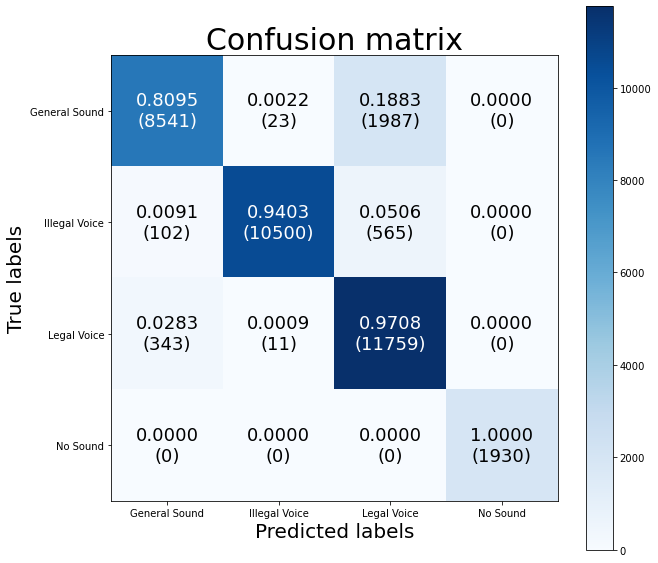

               precision    recall  f1-score   support

General Sound       0.95      0.81      0.87     10551
Illegal Voice       1.00      0.94      0.97     11167
  Legal Voice       0.82      0.97      0.89     12113
     No Sound       1.00      1.00      1.00      1930

     accuracy                           0.92     35761
    macro avg       0.94      0.93      0.93     35761
 weighted avg       0.92      0.92      0.92     35761



In [10]:
# 테스트셋에 대한 혼동행렬

print(le.classes_)

y_true = np.argmax(y_test, axis=-1)
y_pred = np.argmax(model.predict(x_test), axis=-1)
plotConfusionMat(y_true, y_pred, le)

print(classification_report(y_true, y_pred, target_names=le.classes_))

# 한 파일에 대한 예측 보기

In [11]:
def print_prediction(file_name):
    prediction_feature = np.expand_dims(extract_features(file_name), axis=0)
    predicted_proba_vector = model.predict(prediction_feature)
    
    predicted_class_vector = np.argmax(predicted_proba_vector, axis=-1)
    predicted_class = le.inverse_transform(predicted_class_vector) 
    print("The predicted class is:", predicted_class[0], '\n') 

    predicted_proba = predicted_proba_vector[0]
    for i in range(len(predicted_proba)): 
        print(le.classes_[i], "\t\t : ", format(predicted_proba[i], '.32f') )

In [14]:
filename = '102105-3-0-0.wav'

display(Audio(filename, autoplay=True))
print_prediction(filename)

The predicted class is: No Sound 

General Sound 		 :  0.00000000000000000000000000000000
Illegal Voice 		 :  0.00000000000000000000000000000000
Legal Voice 		 :  0.00000000000000000000000000000000
No Sound 		 :  1.00000000000000000000000000000000


# 전체 데이터셋에 대한 예측 상세히 보기

In [15]:
gsDf = pd.DataFrame(gs, columns=['feature','class_label'])
lvDf = pd.DataFrame(lv, columns=['feature','class_label'])
ivDf = pd.DataFrame(iv, columns=['feature','class_label'])
nsDf = pd.DataFrame(ns, columns=['feature','class_label'])

gs_x = np.array(gsDf.feature.tolist())
lv_x = np.array(lvDf.feature.tolist())
iv_x = np.array(ivDf.feature.tolist())
ns_x = np.array(nsDf.feature.tolist())

In [16]:
gs_predicted = np.argmax(model.predict(gs_x), axis=-1)
lv_predicted = np.argmax(model.predict(lv_x), axis=-1)
iv_predicted = np.argmax(model.predict(iv_x), axis=-1)
ns_predicted = np.argmax(model.predict(ns_x), axis=-1)

In [17]:
print('General Sound')
for i, c in enumerate(gs_predicted):
    if c != 0:
        print(c, gs_name[i])
        
print('Legal Voice')
for i, c in enumerate(lv_predicted):
    if c != 2:
        print(c, lv_name[i])
        
print('Illegal Voice')
for i, c in enumerate(iv_predicted):
    if c != 1:
        print(c, iv_name[i])

print('No Sound')
for i, c in enumerate(ns_predicted):
    if c != 3:
        print(c, ns_name[i])

General Sound
2 G-AS-CRW-0000000005.wav
2 G-AS-CRW-0000000006.wav
2 G-AS-CRW-0000000020.wav
2 G-AS-CRW-0000000026.wav
2 G-AS-CRW-0000000028.wav
2 G-AS-CRW-0000000039.wav
2 G-AS-CRW-0000000048.wav
2 G-AS-CRW-0000000049.wav
2 G-AS-CRW-0000000050.wav
2 G-AS-CRW-0000000064.wav
2 G-AS-CRW-0000000065.wav
2 G-AS-CRW-0000000073.wav
2 G-AS-CRW-0000000078.wav
2 G-AS-CRW-0000000080.wav
2 G-AS-CRW-0000000083.wav
2 G-AS-CRW-0000000087.wav
2 G-AS-CRW-0000000089.wav
2 G-AS-CRW-0000000090.wav
2 G-AS-CRW-0000000091.wav
2 G-AS-CRW-0000000093.wav
2 G-AS-CRW-0000000100.wav
2 G-AS-CRW-0000000105.wav
2 G-AS-CRW-0000000111.wav
2 G-AS-CRW-0000000112.wav
2 G-AS-CRW-0000000114.wav
2 G-AS-CRW-0000000115.wav
2 G-AS-CRW-0000000119.wav
2 G-AS-CRW-0000000122.wav
2 G-AS-CRW-0000000124.wav
2 G-AS-CRW-0000000125.wav
2 G-AS-CRW-0000000126.wav
2 G-AS-CRW-0000000130.wav
2 G-AS-CRW-0000000135.wav
2 G-AS-CRW-0000000136.wav
2 G-AS-CRW-0000000139.wav
2 G-AS-CRW-0000000140.wav
2 G-AS-CRW-0000000141.wav
2 G-AS-CRW-0000000144.wa

2 G-AS-DAP-0000001606.wav
2 G-AS-DAP-0000001610.wav
2 G-AS-DAP-0000001612.wav
2 G-AS-DAP-0000001613.wav
2 G-AS-DAP-0000001614.wav
2 G-AS-DAP-0000001618.wav
2 G-AS-DAP-0000001620.wav
2 G-AS-DAP-0000001621.wav
2 G-AS-DAP-0000001623.wav
2 G-AS-DAP-0000001624.wav
2 G-AS-DAP-0000001629.wav
2 G-AS-DAP-0000001635.wav
2 G-AS-DAP-0000001637.wav
2 G-AS-DAP-0000001640.wav
2 G-AS-DAP-0000001641.wav
2 G-AS-DAP-0000001643.wav
2 G-AS-DAP-0000001644.wav
2 G-AS-DAP-0000001646.wav
2 G-AS-DAP-0000001649.wav
2 G-AS-DAP-0000001650.wav
2 G-AS-DAP-0000001651.wav
2 G-AS-DAP-0000001652.wav
2 G-AS-DAP-0000001655.wav
2 G-AS-DAP-0000001656.wav
2 G-AS-DAP-0000001657.wav
2 G-AS-DAP-0000001660.wav
2 G-AS-DAP-0000001661.wav
2 G-AS-DAP-0000001662.wav
2 G-AS-DAP-0000001663.wav
2 G-AS-DAP-0000001664.wav
2 G-AS-DAP-0000001666.wav
2 G-AS-DAP-0000001669.wav
2 G-AS-DAP-0000001670.wav
2 G-AS-DAP-0000001672.wav
2 G-AS-DAP-0000001674.wav
2 G-AS-DAP-0000001676.wav
2 G-AS-DAP-0000001677.wav
2 G-AS-DAP-0000001678.wav
2 G-AS-DAP-0

2 G-AS-PID-0000000053.wav
2 G-AS-PID-0000000055.wav
2 G-AS-PID-0000000056.wav
2 G-AS-PID-0000000057.wav
2 G-AS-PID-0000000058.wav
2 G-AS-PID-0000000061.wav
2 G-AS-PID-0000000065.wav
2 G-AS-PID-0000000066.wav
2 G-AS-PID-0000000068.wav
2 G-AS-PID-0000000071.wav
2 G-AS-PID-0000000073.wav
2 G-AS-PID-0000000074.wav
2 G-AS-PID-0000000076.wav
2 G-AS-PID-0000000078.wav
2 G-AS-PID-0000000079.wav
2 G-AS-PID-0000000081.wav
2 G-AS-PID-0000000083.wav
2 G-AS-PID-0000000084.wav
2 G-AS-PID-0000000085.wav
2 G-AS-PID-0000000086.wav
2 G-AS-PID-0000000087.wav
2 G-AS-PID-0000000088.wav
2 G-AS-PID-0000000090.wav
2 G-AS-PID-0000000095.wav
2 G-AS-PID-0000000100.wav
2 G-AS-PID-0000000102.wav
2 G-AS-PID-0000000103.wav
2 G-AS-PID-0000000108.wav
2 G-AS-PID-0000000109.wav
2 G-AS-PID-0000000112.wav
1 G-AS-PID-0000000114.wav
2 G-AS-PID-0000000117.wav
2 G-AS-PID-0000000121.wav
2 G-AS-PID-0000000122.wav
2 G-AS-PID-0000000123.wav
2 G-AS-PID-0000000125.wav
2 G-AS-PID-0000000127.wav
2 G-AS-PID-0000000129.wav
2 G-AS-PID-0

2 G-MS-HYI-0000001744.wav
2 G-MS-HYI-0000001751.wav
2 G-MS-HYI-0000001758.wav
2 G-MS-HYI-0000001760.wav
2 G-MS-HYI-0000001761.wav
2 G-MS-HYI-0000001762.wav
2 G-MS-HYI-0000001764.wav
2 G-MS-HYI-0000001765.wav
2 G-MS-HYI-0000001766.wav
2 G-MS-HYI-0000001767.wav
2 G-MS-HYI-0000001768.wav
2 G-MS-HYI-0000001769.wav
2 G-MS-HYI-0000001770.wav
2 G-MS-HYI-0000001781.wav
2 G-MS-HYI-0000001787.wav
2 G-MS-HYI-0000001796.wav
2 G-MS-HYI-0000001801.wav
2 G-MS-HYI-0000001802.wav
2 G-MS-HYI-0000001803.wav
2 G-MS-HYI-0000001804.wav
2 G-MS-HYI-0000001814.wav
2 G-MS-HYI-0000001815.wav
2 G-MS-HYI-0000001816.wav
2 G-MS-HYI-0000001817.wav
2 G-MS-HYI-0000001819.wav
2 G-MS-HYI-0000001820.wav
2 G-MS-HYI-0000001821.wav
2 G-MS-HYI-0000001826.wav
2 G-MS-HYI-0000001832.wav
2 G-MS-HYI-0000001834.wav
2 G-MS-HYI-0000001835.wav
2 G-MS-HYI-0000001836.wav
2 G-MS-HYI-0000001837.wav
2 G-MS-HYI-0000001838.wav
2 G-MS-HYI-0000001839.wav
2 G-MS-HYI-0000001840.wav
2 G-MS-HYI-0000001842.wav
2 G-MS-HYI-0000001847.wav
2 G-MS-HYI-0

2 G-MS-HYU-0000000748.wav
2 G-MS-HYU-0000000749.wav
2 G-MS-HYU-0000000752.wav
2 G-MS-HYU-0000000753.wav
2 G-MS-HYU-0000000754.wav
2 G-MS-HYU-0000000756.wav
2 G-MS-HYU-0000000759.wav
2 G-MS-HYU-0000000760.wav
2 G-MS-HYU-0000000762.wav
2 G-MS-HYU-0000000763.wav
2 G-MS-HYU-0000000764.wav
2 G-MS-HYU-0000000766.wav
2 G-MS-HYU-0000000768.wav
2 G-MS-HYU-0000000770.wav
2 G-MS-HYU-0000000772.wav
2 G-MS-HYU-0000000773.wav
2 G-MS-HYU-0000000777.wav
2 G-MS-HYU-0000000779.wav
2 G-MS-HYU-0000000780.wav
2 G-MS-HYU-0000000781.wav
2 G-MS-HYU-0000000782.wav
2 G-MS-HYU-0000000783.wav
2 G-MS-HYU-0000000784.wav
2 G-MS-HYU-0000000785.wav
2 G-MS-HYU-0000000786.wav
2 G-MS-HYU-0000000787.wav
2 G-MS-HYU-0000000790.wav
2 G-MS-HYU-0000000792.wav
2 G-MS-HYU-0000000793.wav
2 G-MS-HYU-0000000794.wav
2 G-MS-HYU-0000000795.wav
2 G-MS-HYU-0000000796.wav
2 G-MS-HYU-0000000797.wav
2 G-MS-HYU-0000000798.wav
2 G-MS-HYU-0000000799.wav
2 G-MS-HYU-0000000800.wav
2 G-MS-HYU-0000000801.wav
2 G-MS-HYU-0000000802.wav
2 G-MS-HYU-0

2 G-OS-HYU-0000000268.wav
2 G-OS-HYU-0000000269.wav
2 G-OS-HYU-0000000270.wav
2 G-OS-HYU-0000000271.wav
2 G-OS-HYU-0000000272.wav
2 G-OS-HYU-0000000273.wav
2 G-OS-HYU-0000000275.wav
2 G-OS-HYU-0000000277.wav
2 G-OS-HYU-0000000279.wav
2 G-OS-HYU-0000000280.wav
2 G-OS-HYU-0000000286.wav
2 G-OS-HYU-0000000287.wav
2 G-OS-HYU-0000000288.wav
2 G-OS-HYU-0000000289.wav
2 G-OS-HYU-0000000290.wav
2 G-OS-HYU-0000000291.wav
2 G-OS-HYU-0000000292.wav
2 G-OS-HYU-0000000293.wav
2 G-OS-HYU-0000000294.wav
2 G-OS-HYU-0000000298.wav
2 G-OS-HYU-0000000302.wav
2 G-OS-HYU-0000000303.wav
2 G-OS-HYU-0000000304.wav
2 G-OS-HYU-0000000306.wav
2 G-OS-HYU-0000000308.wav
2 G-OS-HYU-0000000309.wav
2 G-OS-HYU-0000000311.wav
2 G-OS-HYU-0000000312.wav
2 G-OS-HYU-0000000313.wav
2 G-OS-HYU-0000000314.wav
2 G-OS-HYU-0000000315.wav
2 G-OS-HYU-0000000316.wav
2 G-OS-HYU-0000000317.wav
2 G-OS-HYU-0000000319.wav
2 G-OS-HYU-0000000320.wav
2 G-OS-HYU-0000000322.wav
2 G-OS-HYU-0000000323.wav
2 G-OS-HYU-0000000324.wav
2 G-OS-HYU-0

2 G-TS-HYU-0000004944.wav
2 G-TS-HYU-0000004945.wav
2 G-TS-HYU-0000004946.wav
2 G-TS-HYU-0000004947.wav
2 G-TS-HYU-0000004948.wav
2 G-TS-HYU-0000004967.wav
2 G-TS-HYU-0000004997.wav
2 G-TS-HYU-0000004998.wav
2 G-TS-HYU-0000004999.wav
2 G-TS-HYU-0000005000.wav
2 G-TS-HYU-0000005001.wav
2 G-TS-HYU-0000005002.wav
2 G-TS-HYU-0000005003.wav
2 G-TS-HYU-0000005004.wav
2 G-TS-HYU-0000005005.wav
2 G-TS-HYU-0000005008.wav
2 G-TS-HYU-0000005009.wav
2 G-TS-HYU-0000005010.wav
2 G-TS-HYU-0000005011.wav
2 G-TS-HYU-0000005012.wav
2 G-TS-HYU-0000005013.wav
2 G-TS-HYU-0000005014.wav
2 G-TS-HYU-0000005015.wav
2 G-TS-HYU-0000005119.wav
2 G-TS-HYU-0000005120.wav
2 G-TS-HYU-0000005130.wav
2 G-TS-HYU-0000005131.wav
2 G-TS-HYU-0000005132.wav
2 G-TS-HYU-0000005133.wav
2 G-TS-HYU-0000005134.wav
2 G-TS-HYU-0000005139.wav
2 G-TS-HYU-0000005140.wav
2 G-TS-HYU-0000005141.wav
2 G-TS-HYU-0000005142.wav
2 G-TS-HYU-0000005143.wav
2 G-TS-HYU-0000005147.wav
2 G-TS-HYU-0000005149.wav
2 G-TS-HYU-0000005150.wav
2 G-TS-HYU-0

2 G-TS-VHC-0000003291.wav
2 G-TS-VHC-0000003295.wav
2 G-TS-VHC-0000003296.wav
2 G-TS-VHC-0000003300.wav
2 G-TS-VHC-0000003305.wav
2 G-TS-VHC-0000003310.wav
2 G-TS-VHC-0000003312.wav
2 G-TS-VHC-0000003313.wav
2 G-TS-VHC-0000003315.wav
2 G-TS-VHC-0000003316.wav
2 G-TS-VHC-0000003321.wav
2 G-TS-VHC-0000003323.wav
2 G-TS-VHC-0000003324.wav
2 G-TS-VHC-0000003328.wav
2 G-TS-VHC-0000003330.wav
2 G-TS-VHC-0000003334.wav
2 G-TS-VHC-0000003335.wav
2 G-TS-VHC-0000003338.wav
2 G-TS-VHC-0000003343.wav
2 G-TS-VHC-0000003347.wav
2 G-TS-VHC-0000003352.wav
2 G-TS-VHC-0000003353.wav
2 G-TS-VHC-0000003356.wav
2 G-TS-VHC-0000003358.wav
2 G-TS-VHC-0000003362.wav
2 G-TS-VHC-0000003365.wav
2 G-TS-VHC-0000003366.wav
2 G-TS-VHC-0000003367.wav
2 G-TS-VHC-0000003373.wav
2 G-TS-VHC-0000003377.wav
2 G-TS-VHC-0000003378.wav
2 G-TS-VHC-0000003379.wav
2 G-TS-VHC-0000003386.wav
2 G-TS-VHC-0000003390.wav
2 G-TS-VHC-0000003391.wav
2 G-TS-VHC-0000003392.wav
2 G-TS-VHC-0000003393.wav
2 G-TS-VHC-0000003395.wav
2 G-TS-VHC-0

0 V-MUV-HY3-0000010483.wav
0 V-MUV-HY3-0000010487.wav
0 V-MUV-HY3-0000010580.wav
0 V-MUV-HY3-0000010978.wav
0 V-MUV-HY3-0000011013.wav
0 V-MUV-HY3-0000011017.wav
0 V-MUV-HY3-0000011132.wav
0 V-MUV-HY3-0000011133.wav
0 V-MUV-HY3-0000011257.wav
0 V-MUV-HY3-0000011268.wav
0 V-MUV-HY3-0000011275.wav
0 V-MUV-HY3-0000011316.wav
0 V-MUV-HY3-0000011425.wav
0 V-MUV-HY3-0000011470.wav
0 V-MUV-HY3-0000011489.wav
0 V-MUV-HY3-0000011490.wav
0 V-MUV-HY3-0000011566.wav
0 V-MUV-HY3-0000011567.wav
0 V-MUV-HY3-0000011569.wav
0 V-MUV-HY3-0000011606.wav
0 V-MUV-HY3-0000011736.wav
0 V-MUV-HY3-0000011742.wav
0 V-MUV-HY3-0000011746.wav
0 V-MUV-HY3-0000011748.wav
0 V-MUV-HY3-0000011749.wav
0 V-MUV-HY3-0000011758.wav
0 V-MUV-HY3-0000011761.wav
0 V-MUV-HY3-0000011785.wav
0 V-MUV-HY3-0000011786.wav
0 V-MUV-HY3-0000011883.wav
0 V-MUV-HY3-0000012594.wav
0 V-MUV-HY3-0000012946.wav
0 V-MUV-HY3-0000012947.wav
0 V-MUV-HY3-0000012955.wav
0 V-MUV-HY3-0000013136.wav
0 V-MUV-HY3-0000013189.wav
0 V-MUV-HY3-0000013246.wav
0

0 V-NA-MYO-0000000227.wav
0 V-NA-MYO-0000000228.wav
2 V-NA-MYO-0000000254.wav
2 V-NA-MYO-0000000256.wav
2 V-NA-MYO-0000000257.wav
2 V-NA-MYO-0000000258.wav
2 V-NA-MYO-0000000259.wav
2 V-NA-MYO-0000000263.wav
2 V-NA-MYO-0000000264.wav
2 V-NA-MYO-0000000265.wav
2 V-NA-MYO-0000000266.wav
2 V-NA-MYO-0000000275.wav
2 V-NA-MYO-0000000286.wav
2 V-NA-MYO-0000000287.wav
2 V-NA-MYO-0000000289.wav
2 V-NA-MYO-0000000292.wav
2 V-NA-MYO-0000000307.wav
2 V-NA-MYO-0000000308.wav
2 V-NA-MYO-0000000331.wav
2 V-NA-MYO-0000000334.wav
2 V-NA-MYO-0000000335.wav
2 V-NA-MYO-0000000343.wav
2 V-NA-MYO-0000000344.wav
2 V-NA-MYO-0000000355.wav
2 V-NA-MYO-0000000356.wav
2 V-NA-MYO-0000000357.wav
2 V-NA-MYO-0000000363.wav
2 V-NA-MYO-0000000379.wav
2 V-NA-MYO-0000000380.wav
2 V-NA-MYO-0000000384.wav
2 V-NA-MYO-0000000390.wav
2 V-NA-MYO-0000000393.wav
2 V-NA-MYO-0000000395.wav
2 V-NA-MYO-0000000397.wav
2 V-NA-MYO-0000000400.wav
2 V-NA-MYO-0000000401.wav
2 V-NA-MYO-0000000402.wav
2 V-NA-MYO-0000000405.wav
2 V-NA-MYO-0

2 V-UA-KHS-0000000061.wav
2 V-UA-KHS-0000000062.wav
2 V-UA-KHS-0000000063.wav
0 V-UA-KHS-0000000066.wav
0 V-UA-KHS-0000000067.wav
2 V-UA-KHS-0000000068.wav
2 V-UA-KHS-0000000071.wav
2 V-UA-KHS-0000000072.wav
2 V-UA-KHS-0000000073.wav
0 V-UA-KHS-0000000078.wav
2 V-UA-KHS-0000000079.wav
2 V-UA-KHS-0000000080.wav
2 V-UA-KHS-0000000081.wav
2 V-UA-KHS-0000000082.wav
0 V-UA-KHS-0000000085.wav
2 V-UA-KHS-0000000086.wav
2 V-UA-KHS-0000000088.wav
0 V-UA-KHS-0000000089.wav
2 V-UA-KHS-0000000092.wav
2 V-UA-KHS-0000000093.wav
0 V-UA-KHS-0000000094.wav
2 V-UA-KHS-0000000095.wav
2 V-UA-KHS-0000000096.wav
2 V-UA-KHS-0000000097.wav
2 V-UA-KHS-0000000099.wav
2 V-UA-KHS-0000000100.wav
2 V-UA-KHS-0000000103.wav
2 V-UA-KHS-0000000104.wav
2 V-UA-KHS-0000000105.wav
2 V-UA-KHS-0000000107.wav
2 V-UA-KHS-0000000108.wav
2 V-UA-KHS-0000000110.wav
2 V-UA-KHS-0000000111.wav
2 V-UA-KHS-0000000112.wav
2 V-UA-KHS-0000000113.wav
2 V-UA-KHS-0000000114.wav
2 V-UA-KHS-0000000116.wav
2 V-UA-KHS-0000000118.wav
2 V-UA-KHS-0

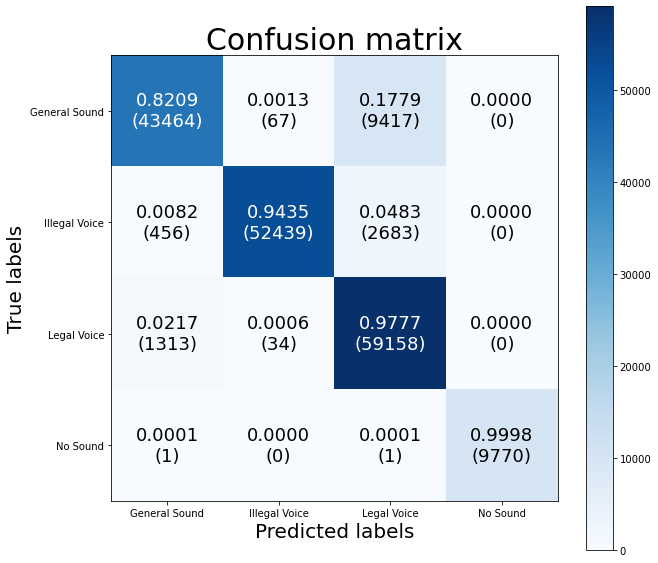

               precision    recall  f1-score   support

General Sound       0.96      0.82      0.89     52948
Illegal Voice       1.00      0.94      0.97     55578
  Legal Voice       0.83      0.98      0.90     60505
     No Sound       1.00      1.00      1.00      9772

     accuracy                           0.92    178803
    macro avg       0.95      0.94      0.94    178803
 weighted avg       0.93      0.92      0.92    178803



In [18]:
y_pred = np.argmax(model.predict(X), axis=-1)
y_true = le.fit_transform(y)

plotConfusionMat(y_true, y_pred, le)

print(classification_report(y_true, y_pred, target_names=le.classes_))

# 특징 시각화

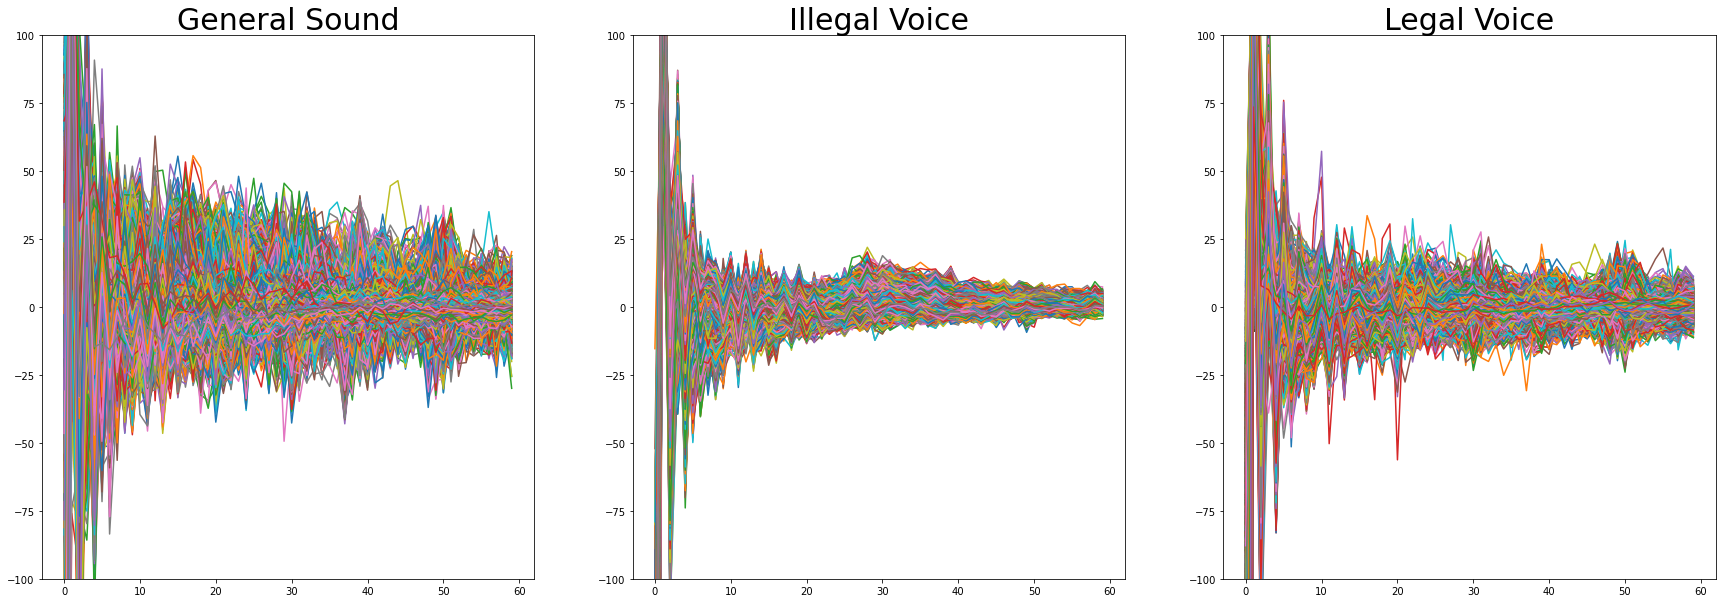

In [19]:
x_values = np.arange(60)

plt.rcParams["figure.figsize"] = (30, 10)

plt.subplot(1, 3, 1)
plt.title('General Sound', fontsize=30)
plt.ylim([-100, 100])
for x in gs:
    plt.plot(x_values, x[0])
    
plt.subplot(1, 3, 2)
plt.title('Illegal Voice', fontsize=30)
plt.ylim([-100, 100])
for x in iv:
    plt.plot(x_values, x[0])
    
plt.subplot(1, 3, 3)
plt.title('Legal Voice', fontsize=30)
plt.ylim([-100, 100])
for x in lv:
    plt.plot(x_values, x[0])

plt.show()